# 1: Filter NeverWorld2 data using diffusion-based filters
* Assumes that you have already run `make_bottom_mask.ipynb`

In [1]:
filter_fac = 32  # filters 1 / 32 degree --> filter_fac / 32 degree; choose filter_fac = 16, 32, 64, 128 to reproduce figures in Loose et al. (2022)
end_time = 2500  # choose from 2500, 2600, 2700, 2800, 2900 
bleck = True
lorenz = True

In [2]:
import numpy as np
import xarray as xr
import dask

In [4]:
gpu = True  # using gpu will considerably speed up the filter computations

## Get a view of Neverworld2 data

In [5]:
path = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
run = 'nw2_0.03125deg_N15_baseline_hmix20'
chunks = {'time': 1, 'zl':1}
nr_days = 100

st = xr.open_dataset('%s/%s/static.nc' % (path,run), decode_times=False)
sn = xr.open_dataset('%s/%s/snapshots_%08d.nc' % (path, run, end_time-nr_days+5), decode_times=False, chunks=chunks)
av = xr.open_dataset('%s/%s/averages_%08d.nc' % (path, run, end_time-nr_days+2), decode_times=False, chunks=chunks)

Bottom mask (was computed in `make_bottom_mask.ipynb`)

In [6]:
scratchpath = '/glade/scratch/noraloose/'
av_mask = xr.open_dataset('%s/%s/averages_%08d_bottom_mask.nc' % (scratchpath, run, end_time-nr_days+2), decode_times=False, chunks=chunks) 
av['bottom_mask'] = av_mask['bottom_mask']  # = 1 if the lower interface of layer n is within the bottom boundary layer, and = 0 otherwise
av['bottom_mask'].attrs = av['bottom_mask'].attrs

In [7]:
sn.time

<xarray.DataArray 'time' (time: 20)>
array([2405., 2410., 2415., 2420., 2425., 2430., 2435., 2440., 2445., 2450.,
       2455., 2460., 2465., 2470., 2475., 2480., 2485., 2490., 2495., 2500.])
Coordinates:
  * time     (time) float64 2.405e+03 2.41e+03 2.415e+03 ... 2.495e+03 2.5e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS

In [8]:
av.time

<xarray.DataArray 'time' (time: 20)>
array([2402.5, 2407.5, 2412.5, 2417.5, 2422.5, 2427.5, 2432.5, 2437.5, 2442.5,
       2447.5, 2452.5, 2457.5, 2462.5, 2467.5, 2472.5, 2477.5, 2482.5, 2487.5,
       2492.5, 2497.5])
Coordinates:
  * time     (time) float64 2.402e+03 2.408e+03 ... 2.492e+03 2.498e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS
    bounds:          time_bnds

Some missing 5-day average diagnostics are computed from snapshots. Since the snapshots time steps in `sn` are taken at the *end* of the 5-day average windows in `av` (see above), we can try and see if we have snapshot data for the 100 previous days, to be able to recover average data for the *first* 5-day window.

In [9]:
previous_sn_file = '%s/%s/snapshots_%08d.nc' % (path, run, end_time-2*nr_days+5)
from os.path import exists
if exists(previous_sn_file):
    sn_previous = xr.open_dataset(previous_sn_file, decode_times=False, chunks=chunks)
    previous = True
else: 
    previous = False
previous

True

In [10]:
sn_previous.time

<xarray.DataArray 'time' (time: 20)>
array([2305., 2310., 2315., 2320., 2325., 2330., 2335., 2340., 2345., 2350.,
       2355., 2360., 2365., 2370., 2375., 2380., 2385., 2390., 2395., 2400.])
Coordinates:
  * time     (time) float64 2.305e+03 2.31e+03 2.315e+03 ... 2.395e+03 2.4e+03
Attributes:
    long_name:       time
    units:           days since 0001-01-01 00:00:00
    cartesian_axis:  T
    calendar_type:   THIRTY_DAY_MONTHS
    calendar:        THIRTY_DAY_MONTHS

## Prepare NW2 grid information

In [11]:
from xgcm import Grid

Nx = np.size(st.xh)
Ny = np.size(st.yh)

# symmetric
coords = {
    'X': {'center': 'xh', 'outer': 'xq'},
    'Y': {'center': 'yh', 'outer': 'yq'},
    'Z': {'center': 'zl', 'outer': 'zi'} 
}
metrics = {
    ('X',):['dxCu','dxCv','dxT','dxBu'],
    ('Y',):['dyCu','dyCv','dyT','dyBu'],
    ('X', 'Y'): ['area_t', 'area_u', 'area_v']
}
st['zl'] = av['zl']
st['zi'] = av['zi']

grid = Grid(st, coords=coords, periodic=['X'])

st['dxT'] = grid.interp(st.dxCu,'X')
st['dyT'] = grid.interp(st.dyCv,'Y', boundary='fill')
st['dxBu'] = grid.interp(st.dxCv,'X')
st['dyBu'] = grid.interp(st.dyCu,'Y',boundary='fill')

grid = Grid(st, coords=coords, periodic=['X'], metrics=metrics)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> outer
  * outer    xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> outer
  * outer    yq --> center
Z Axis (not periodic, boundary=None):
  * center   zl --> outer
  * outer    zi --> center

## Compute missing / additional diagnostics

### Compute thickness-weighted KE: $hKE = \frac{1}{2} h |\mathbf{u}|^2$

$hKE_n = h_n KE_n$, where $KE_n =\frac{1}{2}|\mathbf{u}_n|^2 $ is the kinetic energy density output by the model.

In [12]:
av['hKE'] = av['h'] * av['KE']
av['hKE'].attrs = {'units' : 'm3 s-2', 'long_name': 'thickness-weighted kinetic energy'}

sn['hKE'] = sn['h'] * sn['KE']
sn['hKE'].attrs = {'units' : 'm3 s-2', 'long_name': 'thickness-weighted kinetic energy'}

### Compute thickness tendencies
from continuity equation:
$$
\underbrace{\partial_t h}_\text{dhdt} = - \nabla\cdot(h\mathbf{u})
$$

In [13]:
uflux = grid.diff(av['uh'].fillna(value=0),'X')
vflux = grid.diff(av['vh'].fillna(value=0),'Y', boundary='fill')
dhdt = - (uflux + vflux) / st.area_t  # finite volume discretization
    
av['dhdt'] = dhdt.where(st.wet)
av['dhdt'].attrs = {'units' : 'm/s', 'long_name': 'Layer thickness tendency, computed from flux divergence'}
av['dhdt'] = av['dhdt'].chunk({'xh': Nx, 'yh': Ny})

### Compute $\eta^2$

$
    \eta_k = -D + \sum_{i=k+1}^N h_i
$
is diagnostic, saved as `e`.

In [14]:
av['e2'] = av['e']**2
av['e2'].attrs = {'units' : 'm2', 'long_name': 'Interface height squared'}

In [15]:
sn['e2'] = sn['e']**2
sn['e2'].attrs = {'units' : 'm2', 'long_name': 'Interface height squared'}

sn_previous['e2'] = sn_previous['e']**2
sn_previous['e2'].attrs = {'units' : 'm2', 'long_name': 'Interface height squared'}

### Compute $\partial_t(uh), \partial_t(vh), \partial_t\eta, \partial_t(\eta^2)$ from snapshots

$$
    \frac{d}{dt} uh = \text{time-average}\left(\partial_t (uh) \right) = \frac{1}{\tau_1-\tau_0} \int_{\tau_0}^{\tau_1} \partial_t (uh) dt = \frac{uh(\tau_1) - uh(\tau_0)}{\tau_1-\tau_0}.
$$
and similarly for the other partial derivatives

In [16]:
if np.all(av.average_DT == av.average_DT[0]):
    deltat = av.average_DT[0] * 24 * 60 * 60
else: 
    raise AssertionError('averaging intervals vary')

In [17]:
if np.array_equal(av.time_bnds[:,1], sn.time) :
    duhdt = sn['uh'] - sn['uh'].shift(time=1)
    duhdt = duhdt / deltat
    duhdt['time'] = av['uh'].time
    
    dvhdt = sn['vh'] - sn['vh'].shift(time=1)
    dvhdt = dvhdt / deltat
    dvhdt['time'] = av['vh'].time
else: 
    raise AssertionError('av and sn datasets not compatitble')

if previous and sn_previous.time[-1].values == av.time_bnds[0,0].values:
    data = sn['uh'].isel(time=0) - sn_previous['uh'].isel(time=-1)
    data = data / deltat
    duhdt = xr.where(av.time==av.time[0], data, duhdt)  
    
    data = sn['vh'].isel(time=0) - sn_previous['vh'].isel(time=-1)
    data = data / deltat
    dvhdt = xr.where(av.time==av.time[0], data, dvhdt)  
else:
    previous = False
    
av['duhdt'] = duhdt
av['duhdt'].attrs = {'units' : 'm3 s-2', 'long_name': 'Zonal thickness flux tendency'}

av['dvhdt'] = dvhdt
av['dvhdt'].attrs = {'units' : 'm3 s-2', 'long_name': 'Meridional thickness flux tendency'}

In [18]:
if np.array_equal(av.time_bnds[:,1], sn.time) :
    dedt = sn['e'] - sn['e'].shift(time=1)
    dedt = dedt / deltat
    dedt['time'] = av['e'].time

    de2dt = sn['e2'] - sn['e2'].shift(time=1)
    de2dt = de2dt / deltat
    de2dt['time'] = av['e2'].time
else: 
    raise AssertionError('av and sn datasets not compatible')

if previous and sn_previous.time[-1].values == av.time_bnds[0,0].values:
    data = sn['e'].isel(time=0) - sn_previous['e'].isel(time=-1)
    data = data / deltat
    dedt = xr.where(av.time==av.time[0], data, dedt)  
    
    data = sn['e2'].isel(time=0) - sn_previous['e2'].isel(time=-1)
    data = data / deltat
    de2dt = xr.where(av.time==av.time[0], data, de2dt)  
else:
    previous = False
    
av['de_dt'] = dedt
av['de_dt'].attrs['long_name'] = 'Tendency of interface height'

av['de_dt'].attrs = {'units' : 'm s-1', 'long_name': 'Tendency of interface height'}

av['de2_dt'] = de2dt
av['de2_dt'].attrs = {'units' : 'm2 s-1', 'long_name': 'Tendency of squared interface height'}

### Compute $ u\partial_t h = \partial_t(uh) - h\partial_tu$ and  $v\partial_t h = \partial_t(vh) - h\partial_tv$

In [19]:
av['u_dhdt'] = av['duhdt'] / st['dyCu'] - av['h_du_dt']
av['u_dhdt'].attrs = {'units' : 'm2 s-2', 'long_name': 'Zonal velocity times thickness tendency'}

av['v_dhdt'] = av['dvhdt'] / st['dxCv'] - av['h_dv_dt']
av['v_dhdt'].attrs = {'units' : 'm2 s-2', 'long_name': 'Meridional velocity times thickness tendency'}

### Compute reduced gravity
$$
    g_k' = g (\rho_{k+1} - \rho_k) / \rho_o
$$

$\prime{g}_0 = 10.226$


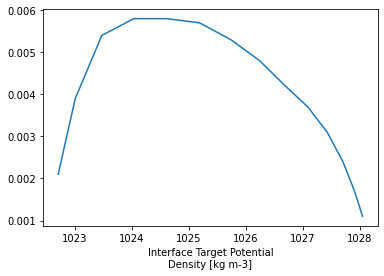

In [20]:
rho_ref = 1000  # reference density in NeverWorld2
gprime = 10 * grid.diff(av.zl,'Z',boundary='fill') / rho_ref
gprime[15] = np.nan
print('$\prime{g}_0 = %g$' % (gprime[0]))
gprime.isel(zi=slice(1,15)).plot()

### Compute Montgomery potential
$$
    M_n = \sum_{k=0}^{n-1} g_k' \eta_k
$$

In [21]:
MP = grid.cumsum(gprime * av['e'],'Z')  # Montgomery potential
av['MP'] = MP.transpose('time', 'zl', 'yh', 'xh')  # reorder coordinates
av['MP'].attrs = {'units' : 'm2 s-2', 'long_name': 'Montgomery potential'}

### Compute pressure flux divergence `uhM_div` = $\nabla\cdot(u_nh_nM_n)$

In [22]:
# pressure flux
uhM = av['uh'] / st['dyCu'] * grid.interp(av['MP'].fillna(value=0), 'X', metric_weighted=['X','Y'])
uhM = uhM.chunk({'xq':Nx+1})

vhM = av['vh'] / st['dxCv'] * grid.interp(av['MP'].fillna(value=0),'Y', boundary='fill', metric_weighted=['X','Y'])
vhM = vhM.chunk({'yq':Ny+1})

# pressure flux divergence
uflux = grid.diff((uhM * st['dyCu']).fillna(value=0), 'X')
vflux = grid.diff((vhM * st['dxCv']).fillna(value=0), 'Y', boundary='fill')

av['uhM_div'] = (uflux + vflux).where(st.wet) / st.area_t
av['uhM_div'].attrs = {'units' : ' m3 s-3', 'long_name': 'Pressure flux divergence'}

### Add up barotropic and baroclinic pressure term contributions

$$
\underbrace{- \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2}}_\text{PFu+ u_BT_accel}
$$

In [23]:
av['PFu+u_BT_accel'] = av['PFu'] + av['u_BT_accel']
av['PFu+u_BT_accel'].attrs = {'units' : 'm s-2', 'long_name': 'Zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFu+u_BT_accel_visc_rem'] = av['PFu_visc_rem'] + av['u_BT_accel_visc_rem']
av['PFu+u_BT_accel_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFv+v_BT_accel'] = av['PFv'] + av['v_BT_accel']
av['PFv+v_BT_accel'].attrs = {'units' : 'm s-2', 'long_name': 'Meridional Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PFv+v_BT_accel_visc_rem'] = av['PFv_visc_rem'] + av['v_BT_accel_visc_rem']
av['PFv+v_BT_accel_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of meridional Pressure Force Acceleration (incl. barotropic anomaly)'}

av['PE_to_KE+KE_BT'] = av['PE_to_KE'] + av['KE_BT']
av['PE_to_KE+KE_BT'].attrs = {'units' : 'm3 s-3', 'long_name': 'Potential to Kinetic Energy Conversion of Layer (incl. barotropic)'}

av['h_PFu+u_BT_accel'] = av['h_PFu'] + av['h_u_BT_accel']
av['h_PFu+u_BT_accel'].attrs = {'units' : 'm2 s-2', 'long_name': 'Thickness Multiplied Zonal Pressure Force Acceleration (incl. barotropic anomaly)'}

av['h_PFv+v_BT_accel'] = av['h_PFv'] + av['h_v_BT_accel']
av['h_PFv+v_BT_accel'].attrs = {'units' : 'm2 s-2', 'long_name': 'Thickness Multiplied Meridional Pressure Force Acceleration (incl. barotropic anomaly)'}

### Close visc-rem multiplied velocity budget (in exact manner)
Original momentum budget (zonal direction):
\begin{align}
    \underbrace{\frac{\partial \mathbf{u}_k}{\partial t}}_\text{dudt} + \underbrace{\left(\frac{{f} + {\zeta}_k}{h_k} \right) \hat{\mathbf{k}} \times \left( \mathbf{u}_k h_k \right) + \nabla K_k}_\text{- CAu} = \underbrace{- \sum_{i=1}^{k} g_{i-1/2}^\prime \nabla \eta_{i-1/2}}_\text{PFu+ u_BT_accel} + \underbrace{F_{hor}}_\text{diffu} + \underbrace{F_{vert}}_\text{du_dt_visc}
    \; 
    \label{eqn:u} \;,
\end{align}

The visc-rem multiplied velocity budget (in zonal direction) is given by

    dudt = CAu_visc_rem + PFv_visc_rem + u_BT_accel_visc_rem + diffu_visc_rem + du_dt_visc_rem  (*),
    
see https://github.com/ocean-eddy-cpt/MOM6/pull/10. The modified momentum budget (*)
1. filters out the balance between PFu and du_dt_visc in vanished layers,
2. leaves the momentum budget as is in non-vanished layers.

The first aspect is desirable when spatially filtering the terms on the right hand side of (*). In the unmodified budget, the filter will spread high PFu / du_dt_visc values from vanished layers into the interior ocean, which would contaminate the budgets. The problem is solved when the PFu / du_dt_visc balance is masked out in vanished layers from the get-go. Note that this problem mainly arises for non-TWA diagnostics, i.e., we don't have to massage h_PFu / h_du_dt_visc (since multiplication of h already takes care of masking in vanished layers).

The first 4 terms on the right hand side of (*) are diagnostics of the model output, and the 5th term can be inferred by

    du_dt_visc_rem = dudt - CAu_visc_rem - PFv_visc_rem - u_BT_accel_visc_rem - diffu_visc_rem,
    
as done in the next cell.

In [24]:
av['du_dt_visc_rem'] = av['dudt'] - av['CAu_visc_rem'] - av['PFu_visc_rem'] - av['u_BT_accel_visc_rem'] - av['diffu_visc_rem']
av['dv_dt_visc_rem'] = av['dvdt'] - av['CAv_visc_rem'] - av['PFv_visc_rem'] - av['v_BT_accel_visc_rem'] - av['diffv_visc_rem']
av['du_dt_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal acceleration from vertical viscosity'}
av['dv_dt_visc_rem'].attrs = {'units' : 'm s-2', 'long_name': 'Viscous remnant fraction of zonal acceleration from vertical viscosity'}

# Filtering

In [25]:
import gcm_filters

In [26]:
gcm_filters.__version__

'0.1.dev64+g73baa9e.d20210210'

In [27]:
if gpu:
    import cupy as cp
    from dask_cuda import LocalCUDACluster
    from dask.distributed import Client

    cluster = LocalCUDACluster()
    client = Client(cluster)

distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/noraloose/energy_cycles/dask-worker-space/worker-z8xx1amr', purging
distributed.preloading - INFO - Import preload module: dask_cuda.initialize


### Transform symmetric data to non-symmetric data

In [28]:
av_orig = av.copy()
sn_orig = sn.copy()

In [29]:
av = av.astype(np.float64)  # to avoid numerical instability
sn = sn.astype(np.float64)  # to avoid numerical instability

In [30]:
av = av.isel(xq = slice(1,None), yq=slice(1,None))
sn = sn.isel(xq = slice(1,None), yq=slice(1,None))

### New datasets for filtered fields

In [31]:
# new xarray datasets for filtered fields
av_f_tmp = xr.Dataset() 
av_f = xr.Dataset()
sn_f_tmp = xr.Dataset() 
sn_f = xr.Dataset()

for dim in av.dims:
    av_f_tmp[dim] = av[dim]  # temporary dataset with non-symmetric dimensions
for dim in sn.dims:
    sn_f_tmp[dim] = sn[dim]  # temporary dataset with non-symmetric dimensions    
for dim in av_orig.dims:
    av_f[dim] = av_orig[dim]  # dataset with symmetric dimensions
for dim in sn_orig.dims:
    sn_f[dim] = sn_orig[dim]  # dataset with symmetric dimensions  
av_f['average_DT'] = av_orig['average_DT']
av_f['time_bnds'] = av_orig['time_bnds']

### Use Gaussian filter shape and simple fixed factor (see Grooms et al., 2021)

In [32]:
filter_shape = gcm_filters.FilterShape.GAUSSIAN
gcm_filters.required_grid_vars(gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED)

['area', 'wet_mask']

For large filter factors, use `n_iterations > 1`, see https://gcm-filters.readthedocs.io/en/latest/factored_gaussian.html

In [33]:
if filter_fac == 128:
    n_iterations = 12
elif filter_fac == 64:
    n_iterations = 3
else:
    n_iterations = 1

## T-fields

In [34]:
wet_mask = st.wet
area = st.area_t
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yh': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [35]:
filter_t = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )
filter_t

Filter(filter_scale=32, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

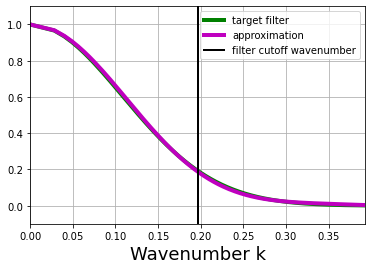

In [36]:
filter_t.plot_shape()

#### Filter averages

In [37]:
namelist = ['h', 'dhdt', 'e', 'e2', 'de_dt', 'de2_dt', 'hKE', 'uhM_div', 'bottom_mask', 
            'KE_adv', 'PE_to_KE+KE_BT', 'KE_visc', 'KE_stress', 'KE_horvisc']  # needed for both energy cycles

In [38]:
for name in namelist:
    field = av[name]
    if gpu:
        field.data = field.data.map_blocks(cp.asarray)        
    field_filtered = filter_t.apply(field, dims=['yh', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f[name] = field_filtered.where(st.wet)           

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

#### Finalize filtered bottom mask

The **filtered bottom mask** will be useful to decompose the MKE vertical stresses into MKE bottom drag vs. MKE vertical viscosity contributions (in `compute_2d_Lorenz_cycle.ipynb` and `compute_2d_Bleck_cycle.ipynb`).

The original bottom mask (`av.bottom_mask`) had binary values: 0 and 1. The filtered bottom mask that is generated by the cell above has values in [0, 1]. To obtain a binary filtered mask, we set values greater than `threshold` to 1, where `threshold` is a value between 0 and 1. Below, we choose `threshold=0.2` because the Gaussian filter shape has approximately a value of 0.2 at the filter cutoff wavenumber (see above figure).

In [39]:
threshold = 0.2
av_f['bottom_mask'] = xr.where(av_f['bottom_mask'] > threshold, 1, 0)   

In [40]:
mask = av_f['bottom_mask'].isel(time=-1).compute()
eta = av_f['e'].isel(time=-1).compute()
eta_x = grid.interp(eta, 'X', boundary='fill')
eta_y = grid.interp(eta, 'Y', boundary='fill')

In [41]:
import matplotlib.pyplot as plt

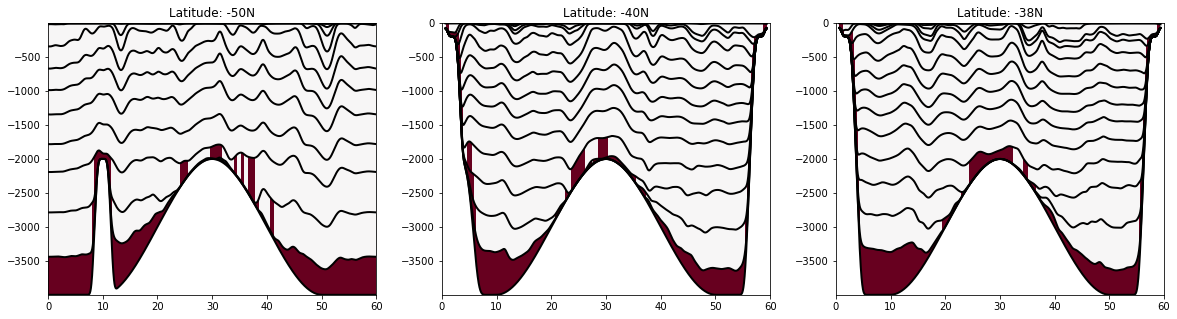

In [42]:
yhlist = [-50, -40, -38]
vmax = 1
fig, axs = plt.subplots(1,3,figsize=(20,5))
for yh, ax in zip(yhlist, axs):
    for i in range(16):
        ax.plot(st.xh, eta.isel(zi=i).sel(yh=yh, method="nearest"), linewidth=2, color='k')
    p = ax.pcolormesh(st.xq, eta_x.fillna(value=0).sel(yh=yh, method="nearest"), mask.sel(yh=yh, method="nearest"),
                        vmax=vmax, vmin=-vmax, cmap='RdBu_r')

    ax.set_title('Latitude: %iN' %yh)

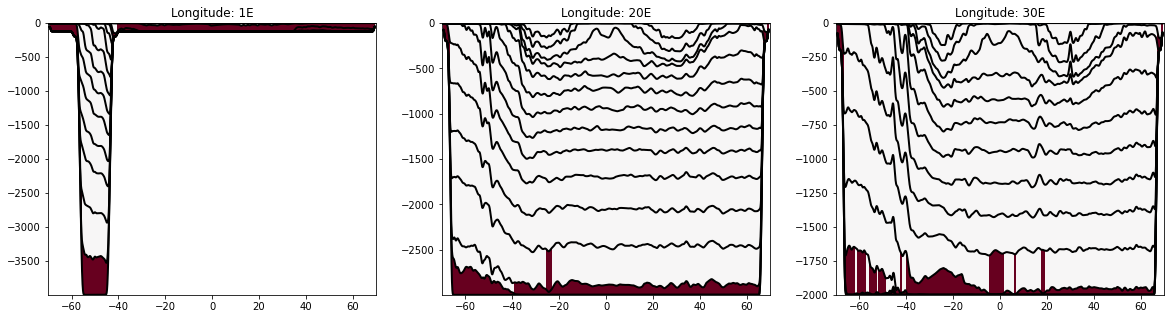

In [43]:
xhlist = [1, 20, 30]
vmax = 1

fig,axs = plt.subplots(1,3,figsize=(20,5))
for xh, ax in zip(xhlist, axs.flatten()):
    for i in range(16):
        ax.plot(st.yh, eta.isel(zi=i).sel(xh=xh, method="nearest"), linewidth=2, color='k')
    p = ax.pcolormesh(st.yq, eta_y.fillna(value=0).sel(xh=xh, method="nearest"), mask.sel(xh=xh, method="nearest"),
                         vmax=vmax, vmin=-vmax, cmap='RdBu_r')
    ax.set_title('Longitude: %iE' %xh)

#### Filter snapshots

In [44]:
namelist = ['h','hKE']  # needed for both energy cycles

In [45]:
for name in namelist:
    field = sn[name]
    if gpu:
        field.data = field.data.map_blocks(cp.asarray)        
    field_filtered = filter_t.apply(field, dims=['yh', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f[name] = field_filtered.where(st.wet)           

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + sn[name].attrs['long_name']

## U-fields

In [46]:
wet_mask = st.wet_u.isel(xq=slice(1,None))
area = st.area_u.isel(xq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)

    area = area.chunk({'yh': Ny,'xq': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [47]:
filter_u = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )  
filter_u

Filter(filter_scale=32, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

#### Filter averages

In [48]:
namelist = ['uh']  # needed for both energy cycles
namelist_lorenz = ['u', 'PFu+u_BT_accel_visc_rem', 'CAu_visc_rem', 'du_dt_str_visc_rem', 'diffu_visc_rem', 'du_dt_visc_rem']
namelist_bleck = ['h_CAu', 'h_PFu+u_BT_accel', 'h_diffu', 'h_du_dt_visc', 'h_du_dt_str', 'u_dhdt']
if lorenz:
    namelist = namelist + namelist_lorenz
if bleck:
    namelist = namelist + namelist_bleck
namelist

['uh',
 'u',
 'PFu+u_BT_accel_visc_rem',
 'CAu_visc_rem',
 'du_dt_str_visc_rem',
 'diffu_visc_rem',
 'du_dt_visc_rem',
 'h_CAu',
 'h_PFu+u_BT_accel',
 'h_diffu',
 'h_du_dt_visc',
 'h_du_dt_str',
 'u_dhdt']

In [49]:
for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_u.apply(field, dims=['yh', 'xq'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered 
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yh', 'xq') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the western edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]
    av_f[name] = xr.where(av_f.xq==av_f.xq[0], av_f[name].roll(xq=1,roll_coords=False), av_f[name])
    av_f[name] = av_f[name].where(st.wet_u)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yh', 'xq')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of c

#### Filter snapshots

In [50]:
namelist = []
namelist_lorenz = ['u']
namelist_bleck = ['uh']

if lorenz:
    namelist = namelist + namelist_lorenz
if bleck:
    namelist = namelist + namelist_bleck
namelist

['u', 'uh']

In [51]:
for name in namelist:
    field = sn[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_u.apply(field, dims=['yh', 'xq'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f_tmp[name] = field_filtered 
    sn_f_tmp[name] = sn_f_tmp[name].transpose('time', 'zl', 'yh', 'xq') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the western edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        sn_f[name] = sn_f_tmp[name]
    sn_f[name] = xr.where(sn_f.xq==sn_f.xq[0], sn_f[name].roll(xq=1,roll_coords=False), sn_f[name])
    sn_f[name] = sn_f[name].where(st.wet_u)
    sn_f[name] = sn_f[name].transpose('time', 'zl', 'yh', 'xq')

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + sn[name].attrs['long_name']

/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


## V-fields

In [52]:
wet_mask = st.wet_v.isel(yq=slice(1,None))
area = st.area_v.isel(yq=slice(1,None))
if gpu:
    wet_mask = wet_mask.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    wet_mask.data = wet_mask.data.map_blocks(cp.asarray)
    
    area = area.chunk({'yq': Ny,'xh': Nx}) # 1 chunk
    area.data = area.data.map_blocks(cp.asarray)

In [53]:
filter_v = gcm_filters.Filter(
        filter_scale=filter_fac,
        dx_min=1,
        n_iterations=n_iterations,
        filter_shape=filter_shape,
        grid_type=gcm_filters.GridType.REGULAR_WITH_LAND_AREA_WEIGHTED,
        grid_vars={'area': area, 'wet_mask': wet_mask}
    )    
filter_v

Filter(filter_scale=32, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=36, n_iterations=1, grid_type=<GridType.REGULAR_WITH_LAND_AREA_WEIGHTED: 4>)

#### Filter averages

In [54]:
namelist = ['vh']  # needed for both energy cycles
namelist_lorenz = ['v', 'PFv+v_BT_accel_visc_rem', 'CAv_visc_rem', 'dv_dt_str_visc_rem', 'diffv_visc_rem', 'dv_dt_visc_rem']
namelist_bleck = ['h_CAv', 'h_PFv+v_BT_accel', 'h_diffv', 'h_dv_dt_visc', 'h_dv_dt_str', 'v_dhdt']
if lorenz:
    namelist = namelist + namelist_lorenz
if bleck:
    namelist = namelist + namelist_bleck
namelist

['vh',
 'v',
 'PFv+v_BT_accel_visc_rem',
 'CAv_visc_rem',
 'dv_dt_str_visc_rem',
 'diffv_visc_rem',
 'dv_dt_visc_rem',
 'h_CAv',
 'h_PFv+v_BT_accel',
 'h_diffv',
 'h_dv_dt_visc',
 'h_dv_dt_str',
 'v_dhdt']

In [55]:
for name in namelist:
    field = av[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_v.apply(field, dims=['yq', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    av_f_tmp[name] = field_filtered  
    av_f_tmp[name] = av_f_tmp[name].transpose('time', 'zl', 'yq', 'xh') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the southern edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        av_f[name] = av_f_tmp[name]

    # set yq = 0 to nan's (all land):        
    av_f[name] = xr.where(av_f.yq==av_f.yq[0], np.nan, av_f[name])
    av_f[name] = av_f[name].where(st.wet_v)
    av_f[name] = av_f[name].transpose('time', 'zl', 'yq', 'xh')

    av_f[name].attrs = av[name].attrs
    av_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of c

#### Filter snapshots

In [56]:
namelist = []
namelist_lorenz = ['v']
namelist_bleck = ['vh']

if lorenz:
    namelist = namelist + namelist_lorenz
if bleck:
    namelist = namelist + namelist_bleck
namelist

['v', 'vh']

In [57]:
for name in namelist:
    field = sn[name]
        
    if gpu:
        field.data = field.data.map_blocks(cp.asarray) 
    field_filtered = filter_v.apply(field, dims=['yq', 'xh'])

    if gpu:
        field_filtered.data = field_filtered.data.map_blocks(cp.asnumpy)

    sn_f_tmp[name] = field_filtered  
    sn_f_tmp[name] = sn_f_tmp[name].transpose('time', 'zl', 'yq', 'xh') # reorder coordinates  

    # the following lines take care of re-appending the sliced off dimension at the southern edge
    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        sn_f[name] = sn_f_tmp[name]

    # set yq = 0 to nan's (all land):        
    sn_f[name] = xr.where(sn_f.yq==sn_f.yq[0], np.nan, sn_f[name])
    sn_f[name] = sn_f[name].where(st.wet_v)
    sn_f[name] = sn_f[name].transpose('time', 'zl', 'yq', 'xh')

    sn_f[name].attrs = sn[name].attrs
    sn_f[name].attrs['long_name'] = 'Filtered ' + av[name].attrs['long_name']

/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(
/glade/u/home/noraloose/miniconda3/lib/python3.8/site-packages/dask/array/core.py:4527: PerformanceWarning: Increasing number of chunks by factor of 15
  result = blockwise(


## Save filtered fields

In [58]:
path = '/glade/scratch/noraloose/filtered_data'
filename_av_f = '%s/%s/averages_%08d_filtered_fac%i' %(path, run, end_time-nr_days+2, filter_fac) 
filename_sn_f = '%s/%s/snapshots_%08d_filtered_fac%i' %(path, run, end_time-nr_days+5, filter_fac) 

In [59]:
%time av_f.to_zarr(filename_av_f)

CPU times: user 17min 28s, sys: 46 s, total: 18min 14s
Wall time: 2h 22min 33s


In [60]:
%time sn_f.to_zarr(filename_sn_f)

CPU times: user 45.9 s, sys: 6.46 s, total: 52.4 s
Wall time: 18min 35s
